<b>IMPORTANT</b>: Run the below cell to import the modules from previous challenge.

In [ ]:
%run solution1.ipynb
%run solution2.ipynb
%run solution3.ipynb

# **Coding Challenge Part 4: Learning sentence embedding using a contrastive approach based on NLI dataset [3 Points]**

**Please DO NOT use additional library except the ones that are imported!!**

In this part, you are asked to explore another method that leverages a contrastive approach using NLI dataset.

Tasks **[3 Points]** :

*   Generate a dataloader if this is required for your approach
*   Construct a BERT based model using a contrastive method

### **Implementation explanation**

The contrastive loss is commonly used in tasks like siamese networks for learning embeddings that place similar items close to each other in the embedding space while pushing dissimilar items apart.

**Contrastive Loss** = $(Y)\frac{1}{2}(D)^2 + (1-Y)\frac{1}{2}\{max(0, m - D)\}^2$

Where,
* y is the label indicating whether the pair is similar (y==1) or dissimilar (y==0).
* D is the the cosine distance between the two embeddings (Cosine distance = 1 - Cosine similarity).
* m is the margin, a hyperparameter that specifies how far apart dissimilar points should be in the embedding space.

The first term penalizes the distance between similar points and the second term penalizes the distance between dissimilar points if that distance is less than the margin. The half factors are included for mathematical convenience, making it easier to take derivatives.

Further information: http://yann.lecun.com/exdb/publis/pdf/hadsell-chopra-lecun-06.pdf

I use the same methodoloy as `BERTClassifier()` to get embeddings for a batch and calculate cosine distances. I then plug the distances and the labels in the contrastive loss formula to calculate the loss. Summing or averaging the loss values for a batch produces the same results.



In [15]:
class BertContrastive(nn.Module):
    # add __init__ to construct BertContrastive based on given pretrained BERT
    # add code for forward pass that returns the loss value
    # add aditional method if required
    def __init__(self, weights_path, config_dict):
        super(BertContrastive, self).__init__()
        self.config = Config.from_dict(config_dict)
        self.bert = Bert(config_dict).load_model(weights_path)
        # The cosine distance
        self.distance_metric = lambda x, y: 1-F.cosine_similarity(x, y)
        # Minimum distance between the positive and negative labels
        self.margin = 0.5

    def forward(self, sentence_features, labels=None):
        # Get sentence embeddings
        embeddings = []
        for input_feature in sentence_features:
          input_ids, input_mask = input_feature
          embeddings.append(self.bert(input_ids=input_ids, attention_mask=input_mask)[1])

        emb_anchor, emb_other = embeddings
        distances = self.distance_metric(emb_anchor, emb_other)
        if labels is not None:
          # Formula for contrastive loss
          loss = 0.5 * (labels.float() * distances.pow(2) + (1 - labels).float() * F.relu(self.margin - distances).pow(2))
          return loss.sum()
        else:
          return distances


**Training**

In [16]:
#INFO: model and training configs
model_name = 'prajjwal1/bert-tiny'
num_epochs = 3
batch_size = 8
# num_labels =3
# hidden_size = 128
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
tokenizer = AutoTokenizer.from_pretrained(model_name)
bert_config = {"hidden_size": 128, "num_attention_heads": 2, "num_hidden_layers": 2, "intermediate_size": 512, "vocab_size": 30522}
bert_path = 'bert_tiny.bin'

#WARNING: Change this code if you implemented a different nli loader for this part
nli_dataset = load_nli_dataset('AllNLI.tsv.gz', contrastive=True)

#INFO: tokenize dataset
#WARNING: Use only first 50000 samples and maximum sequence lenght of 128
tokenized_train = tokenize_sentence_pair_dataset(nli_dataset['train'][:50000], tokenizer, max_length=128)

#INFO: generate train_dataloader
train_dataloader = get_dataloader(tokenized_train, batch_size=batch_size)

# Create a BertContrastive with required parameters
###    Replace None with required input based on yor implementation
bert_contrastive = BertContrastive(weights_path=bert_path, config_dict=bert_config)

#INFO: create optimizer and run training loop
optimizer = AdamW(bert_contrastive.parameters(), lr=5e-5)
train_loop(bert_contrastive, optimizer, train_dataloader, num_epochs, device)

0it [00:00, ?it/s]

  0%|          | 0/6250 [00:00<?, ?it/s]

Epoch 1/3 - Average Loss: 0.1904


  0%|          | 0/6250 [00:00<?, ?it/s]

Epoch 2/3 - Average Loss: 0.1467


  0%|          | 0/6250 [00:00<?, ?it/s]

Epoch 3/3 - Average Loss: 0.1258


**Evaluation**

In [17]:
# run evaluation loop
result_from_contrastive = eval_loop(bert_contrastive.bert, test_dataloader, device)
print(f'\nPearson correlation: {result_from_contrastive[0]:.2f}\nSpearman correlation: {result_from_contrastive[1]:.2f}')

  0%|          | 0/1379 [00:00<?, ?it/s]


Pearson correlation: 0.56
Spearman correlation: 0.57


# **Coding Challenge Part 5: Comparison [1 Point]**

In the final part of the coding challenge, you are asked to compare the result of pretrained BERT, classification based BERT, and contrastive method based BERT.

These are the tasks **[1 Point]**:


*   Plot the result for each model
*   Explain the difference between methods and their impact on the result and comparison

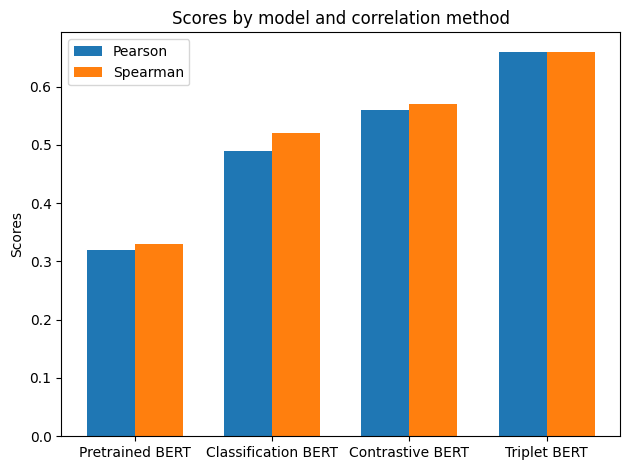

In [23]:
import matplotlib.pyplot as plt

# Triplet BERT is from the optional section below
pearson_scores = {'Pretrained BERT': 0.32, 'Classification BERT': 0.49, 'Contrastive BERT': 0.56, 'Triplet BERT': 0.66}
spearman_scores = {'Pretrained BERT': 0.33, 'Classification BERT': 0.52, 'Contrastive BERT': 0.57, 'Triplet BERT': 0.66}

labels = pearson_scores.keys()
# the label locations
x = np.arange(len(labels))
# the width of the bars
width = 0.35

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, pearson_scores.values(), width, label='Pearson')
rects2 = ax.bar(x + width/2, spearman_scores.values(), width, label='Spearman')

ax.set_ylabel('Scores')
ax.set_title('Scores by model and correlation method')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

fig.tight_layout()

plt.show()

### **Explanation**

**NOTE**: Triplet BERT is from the optional section below.

The results show a consistent improvement in correlation scores as models are further fine-tuned on the NLI dataset with different loss functions. The performance improvement with Contrastive Loss and Multiple Negatives Ranking Loss (MNRL) over Cross Entropy Loss is likely due to their design for similarity learning tasks. Contrastive Loss minimizes the distance between similar pairs and maximizes it for dissimilar pairs, facilitating better similarity representations. MNRL, by considering multiple negative examples, offers a more robust learning of similarity relationships, thus yielding better performance. Contrastive loss and MNRL loss functions aligns better with the inherent nature of this task (measuring sentence similarity), making these loss functions more suited than Cross Entropy Loss, which is traditionally used for classification tasks.



# **[OPTIONAL] Explore an alternative way to improve sentence encoder in terms of *performance* or *efficiency* [6 Points]**

Potential directions:
*   <u>Improve the methodology to compute higher quality sentence embeddings</u> (My choice)  
*   Improve the efficiency during fine-tuning in terms of memory or training time
*   Use different machine learning methods that leverages other resources such as auxillary/teacher models
*   Use different datasets with other training objectives


**You can use any additional model, dataset, library or package for this part!!**

### **Improving sentence embeddings using Multiple Negatives Ranking Loss with hard negatives**

In this approach, I want to continue the momentum of using our custom Tiny BERT implementation with pre-trainined STS weights. Keeping all the hyperparameters (like the max length, batch size, and the number of samples used for training) the same, I just want to focus on improving the methodology of training (loss function) to compute higher quality sentence embeddings.

While increasing the number of datapoints, performing curriculum learning with multiple datasets, model distillation, or increasing the model size seems to be the obvious approach to improve embedding quality, they come with higher compute requirements. I want to preserve all the previous constraints for a fair comparison of the approach below.

**Background**

1. **Contrastive loss**: Operates on pairs: an anchor and a positive or negative example. It aims to minimize the distance between similar pairs and maximize the distance between dissimilar pairs.

2. **Triplet loss**: Operates on triplets: an anchor, a positive, and a negative example. It aims to ensure the anchor is closer to the positive than to the negative by a margin.

**Multiple Negatives Ranking Loss (MNLR)**

**TLDR**: MNLR extends the idea of Triplet loss by considering multiple negative examples instead of just one. In training, an anchor-positive pair is considered alongside several negatives, optimizing the model to produce similar embeddings for the anchor-positive pair while different embeddings for non-pairs.

The training data for MultipleNegativesRankingLoss consists of sentence pairs [(a1, b1), …, (an, bn)] where we assume that (ai, bi) are similar sentences and (ai, bj) are dissimilar sentences for i != j. This loss minimizes the distance between (ai, bi) while it simultaneously maximizes the distance (ai, bj) for all i != j.

We can further improve MultipleNegativesRankingLoss by not only providing pairs, but by providing triplets: [(a1, b1, c1), …, (an, bn, cn)]. The entry for ci are so-called hard-negatives. Using MultipleNegativeRankingLoss with NLI dataset is easy: We define sentences that have an entailment label as positive pairs and contradiction label as hard negatives. So our triplets look like this: (“A soccer game with multiple males playing.”, “Some men are playing a sport.”, “A group of men playing a baseball game.”).


Reference: https://www.sbert.net/examples/training/nli/README.html#multiplenegativesrankingloss


In [16]:
import random

**1. Load and pre-process NLI dataset**

I modify the train samples in `load_nli_dataset()` function to load all possible triplets. Every sentence is mapped to the list of entailments and contradictions that are present in the NLI dataset for this particular sentence. This approach might create duplicates which are handled in the `NoDuplicatesDataLoader()`.

Since I am using the same STS pre-trained Custom Tiny BERT model, I re-use the tokenizer to convert sentence to token ids and create corresponding input masks and pad both of them to the max sequence length.

In [17]:
def load_nli_dataset_triplets(allnli_dataset_path):
  # add code to load NLI dataset in required format
  label_map = {"contradiction": 0, "entailment": 1, "neutral": 2}
  train_data = {}
  dev_samples = []
  test_samples = []
  with gzip.open(allnli_dataset_path, 'rt', encoding='utf8') as fIn:
      reader = csv.DictReader(fIn, delimiter='\t', quoting=csv.QUOTE_NONE)
      for row in tqdm(reader):
          label = row['label']
          if row['split'] == 'dev':
              # Not being used
              dev_samples.append((row['sentence1'], row['sentence2'], label_map[label]))
          elif row['split'] == 'test':
              # Not being used
              test_samples.append((row['sentence1'], row['sentence2'], label_map[label]))
          else:
              # Updated for BertTriplet
              sent1 = row['sentence1']
              sent2 = row['sentence2']
              if sent1 not in train_data:
                  train_data[sent1] = {'contradiction': set(), 'entailment': set(), 'neutral': set()}
              train_data[sent1][label].add(sent2)
              # Also add the opposite
              if sent2 not in train_data:
                  train_data[sent2] = {'contradiction': set(), 'entailment': set(), 'neutral': set()}
              train_data[sent2][label].add(sent1)

  # Providing hard negatives per anchor-positive pair by structuring data like this: (a_1, p_1, n_1), (a_2, p_2, n_2)
  train_samples = []
  for sent1, others in train_data.items():
      if len(others['entailment']) > 0 and len(others['contradiction']) > 0:
          train_samples.append((sent1, random.choice(list(others['entailment'])), random.choice(list(others['contradiction']))))
          train_samples.append((random.choice(list(others['entailment'])), sent1, random.choice(list(others['contradiction']))))


  nli_samples = {
      "train": train_samples,
      "dev": dev_samples,
      "test": test_samples
  }
  return nli_samples

def convert_sentence_to_features(sentence, tokenizer, max_length=128):
  # Convert sentence to features
  tokens = tokenizer.tokenize(sentence)
  # Add the CLS and SEP token for fine-tuned bert model
  tokens = ["[CLS]"] + tokens + ["[SEP]"]
  input_ids = tokenizer.convert_tokens_to_ids(tokens)
  # The mask has 1 for real tokens and 0 for padding tokens
  input_mask = [1] * len(input_ids)
  # Zero-pad up to the sequence length
  padding = [0] * (max_length - len(input_ids))
  input_ids += padding
  input_mask += padding
  input_ids = torch.tensor(input_ids, dtype=torch.long)
  input_mask = torch.tensor(input_mask, dtype=torch.long)

  return input_ids, input_mask


def tokenize_triplet_dataset(train_samples, tokenizer, max_length=128):
  tokenized_train_samples = []
  for (anchor, positive, negative) in tqdm(train_samples):
    # Convert sentences to features
    anchor_ids, anchor_mask = convert_sentence_to_features(anchor, tokenizer, max_length=max_length)
    positive_ids, positive_mask = convert_sentence_to_features(positive, tokenizer, max_length=max_length)
    negative_ids, negative_mask = convert_sentence_to_features(negative, tokenizer, max_length=max_length)
    tokenized_train_samples.append([
        # Storing the text to identify duplicates in NoDuplicatesDataLoader()
        (anchor, positive, negative),
        # Storing input ids and mask for anchor, positive, and negative sentences
        (anchor_ids, anchor_mask),
        (positive_ids, positive_mask),
        (negative_ids, negative_mask)
    ])
  return tokenized_train_samples

**2. Define the similarity metric and the BertTriplet model**

**Cosine similarity**: I use a slightly modified version of the cosine similarity method here to take non-tensors as input and convert them if needed.

**BertTriplet**: The input to this model contains features for 3 sentences (anchor, positive, negative) for each example in a batch. Embeddings are calculated for all the three sentence types in a batched manner to make most of the GPUs. Assuming batch_size of 8, cosine similarities are calculated as 8 (anchors) x 16 (positives + negatives) matrix. Framing this as a classification problem (where the number of classes/labels is 16), the label for ith example in the batch should correspond to the ith index in the output. Rest all the labels are negatives as explained in MNRL above.

Therefore, labels are generated as a sequence of integers [0, ..., batch_size-1] for the batch, indicating the anchor should match the positive example corresponding to the same index. The cosine similarities are scaled and passed to the `nn.CrossEntropyLoss()` to compute the loss. This setup encourages the model to learn embeddings such that the cosine similarity with positive example is higher than with negative examples, thus ensuring similar examples have closer embeddings and dissimilar examples have distant embeddings.

In [18]:
def cos_sim(a, b):
    """
    Computes the cosine similarity cos_sim(a[i], b[j]) for all i and j
    """
    if not isinstance(a, torch.Tensor):
        a = torch.tensor(a)

    if not isinstance(b, torch.Tensor):
        b = torch.tensor(b)

    if len(a.shape) == 1:
        a = a.unsqueeze(0)

    if len(b.shape) == 1:
        b = b.unsqueeze(0)

    a_norm = F.normalize(a, p=2, dim=1)
    b_norm = F.normalize(b, p=2, dim=1)
    return torch.mm(a_norm, b_norm.transpose(0, 1))


class BertTriplet(nn.Module):
  def __init__(self, weights_path, config_dict):
        super(BertTriplet, self).__init__()
        self.config = Config.from_dict(config_dict)
        self.bert = Bert(config_dict).load_model(weights_path)
        self.scale = 20.0
        self.cross_entropy_loss = nn.CrossEntropyLoss()

  def forward(self, sentence_features, labels=None):
        # Get pooled output for all the batches
        embeddings = [self.bert(input_ids=input_ids, attention_mask=input_masks)[1] for (input_ids, input_masks) in sentence_features]

        embeddings_a = embeddings[0]
        embeddings_b = torch.cat(embeddings[1:])

        scores = cos_sim(embeddings_a, embeddings_b) * self.scale
        # Example a[i] should match with b[i]
        labels = torch.tensor(range(len(scores)), dtype=torch.long, device=scores.device)
        # Minimize the negative log-likehood for softmax normalized scores
        batch_loss = self.cross_entropy_loss(scores, labels)
        return batch_loss

**3. Define the DataLoader and the training loop**

**NoDuplicatesDataLoader**: A special data loader to be used with MultipleNegativesRankingLoss. This data loader ensures that there are no duplicate sentences within the same batch.

**Train loop**: The training loop is similar to the one above. The only difference is the flatten out the three sentences: anchor, positive, and negative from each example in the train dataloader. This helps run inference on the complete batch of input instead of individual sentences in each example which is very slow.



In [19]:
class NoDuplicatesDataLoader:
    """DataLoader that removes duplicate texts from a batch"""
    def __init__(self, train_examples, batch_size):
        self.batch_size = batch_size
        self.data_pointer = 0
        self.train_examples = train_examples
        random.shuffle(self.train_examples)

    def __iter__(self):
        for _ in range(self.__len__()):
            batch = []
            texts_in_batch = set()

            # Loop until the batch is full
            while len(batch) < self.batch_size:
                example = self.train_examples[self.data_pointer]

                # Assume the example is valid
                valid_example = True
                for text in example[0]:
                    # If the sentence is already present in the batch then skip
                    if text.strip().lower() in texts_in_batch:
                        valid_example = False
                        break
                # If the example is valid, append the input ids and mask
                if valid_example:
                    batch.append(example[1:])
                    # Save text to check against next example
                    for text in example[0]:
                        texts_in_batch.add(text.strip().lower())

                self.data_pointer += 1
                # Reset the pointer to start if it reaches the end of the training set
                if self.data_pointer >= len(self.train_examples):
                    self.data_pointer = 0
                    random.shuffle(self.train_examples)

            yield batch

    def __len__(self):
        # Calculates the number of examples in the data loader
        return math.floor(len(self.train_examples) / self.batch_size)


def triplet_train_loop(model, optimizer, train_dataloader, num_epochs, device):
  # add code to for training loop
  # use optimizer, train_dataloader, num_epoch and device for training
  # Move the model to the specified device
  model = model.to(device)

  # Training loop
  for epoch in range(num_epochs):
      model.train()  # Set the model to training mode
      total_loss = 0.0

      for batch_examples in tqdm(train_dataloader):

          # Zero the gradients
          optimizer.zero_grad()

          # Initialize lists to hold ids and masks for all examples in the batch
          sentence_features = [
              [[], []], # anchor features
              [[], []], # positive features
              [[], []]  # negative features
          ]
          # Populate the lists with ids and masks from each example
          for example in batch_examples:
              for idx, (ids, mask) in enumerate(example):
                  sentence_features[idx][0].append(ids)
                  sentence_features[idx][1].append(mask)

          # Stack the lists to form a batch tensor
          sentence_features = [
              [torch.stack(item) for item in feature] for feature in sentence_features
          ]
          sentence_features = [torch.stack(feature) for feature in sentence_features]
          sentence_features = torch.stack(sentence_features).to(device)

          # Call the model inference only once for the entire batch
          loss = model(sentence_features)

          # Backward pass
          loss.backward()

          # Update model parameters
          optimizer.step()

          total_loss += loss.item()

      # Print average loss for the epoch
      avg_loss = total_loss / len(train_dataloader)
      print(f"Epoch {epoch + 1}/{num_epochs} - Average Loss: {avg_loss:.4f}")

**4. Initialize the model, its config, and load the dataset**

In [20]:
#INFO: model and training configs
model_name = 'prajjwal1/bert-tiny'
num_epochs = 3
batch_size = 8
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
tokenizer = AutoTokenizer.from_pretrained(model_name)
bert_config = {"hidden_size": 128, "num_attention_heads": 2, "num_hidden_layers": 2, "intermediate_size": 512, "vocab_size": 30522}
bert_path = 'bert_tiny.bin'

#WARNING: Change this code if you implemented a different nli loader for this part
nli_dataset = load_nli_dataset_triplets('AllNLI.tsv.gz')

#INFO: tokenize dataset
#WARNING: Use only first 50000 samples and maximum sequence lenght of 128
tokenized_train = tokenize_triplet_dataset(nli_dataset['train'][:50000], tokenizer, max_length=128)

0it [00:00, ?it/s]

  0%|          | 0/50000 [00:00<?, ?it/s]

**5. Train the BertTriplet model using the Multiple Negatives Ranking Loss**

In [21]:
#INFO: generate train_dataloader
train_dataloader = NoDuplicatesDataLoader(tokenized_train, batch_size=batch_size)

# Create a BertTriplet with required parameters
###    Replace None with required input based on yor implementation
bert_triplet = BertTriplet(weights_path=bert_path, config_dict=bert_config)

#INFO: create optimizer and run training loop
optimizer = AdamW(bert_triplet.parameters(), lr=5e-5)
triplet_train_loop(bert_triplet, optimizer, train_dataloader, num_epochs, device)

  0%|          | 0/6250 [00:00<?, ?it/s]

Epoch 1/3 - Average Loss: 0.9559


  0%|          | 0/6250 [00:00<?, ?it/s]

Epoch 2/3 - Average Loss: 0.5882


  0%|          | 0/6250 [00:00<?, ?it/s]

Epoch 3/3 - Average Loss: 0.4549


**6. Evaluate the embeddings on the STS test dataset**

In [22]:
# run evaluation loop
result_from_triplet = eval_loop(bert_triplet.bert, test_dataloader, device)
print(f'\nPearson correlation: {result_from_triplet[0]:.2f}\nSpearman correlation: {result_from_triplet[1]:.2f}')

  0%|          | 0/1379 [00:00<?, ?it/s]


Pearson correlation: 0.66
Spearman correlation: 0.66


**Conclusion**: Classification using Softmax-loss with NLI data produces (relatively) good sentence embeddings is rather coincidental. The MultipleNegativesRankingLoss is much more intuitive and produces significantly better sentence representations.

**NOTE**: In my submission Email, I stated the scores as 0.60 and 0.61. I apologize for that. There was a small bug in creating batches in the forward pass for the BertTriplet model that gave me those scores. After fixing the bug, I'm getting the new Pearson and Spearman scores as 0.66.